# What does Micrograd do?
In frameworks like TensorFlow or PyTorch, when you call .backward(), a lot of magic happens in C++ to calculate gradients. Micrograd implements this entire process in about 100 lines of pure Python.
### It allows you to:
> Build mathematical expressions (computational graphs).

> Automatically calculate the derivative (gradient) of the output with respect to the input using the Chain Rule.

> Visualize the entire neural network as a graph of nodes and edges.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(-2.001)

25.016002999999998

In [5]:
np.arange(-5, 5, 0.25)
# np.arange("starting_point", "Ending_point(not include)", "space_btw_2_int")

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

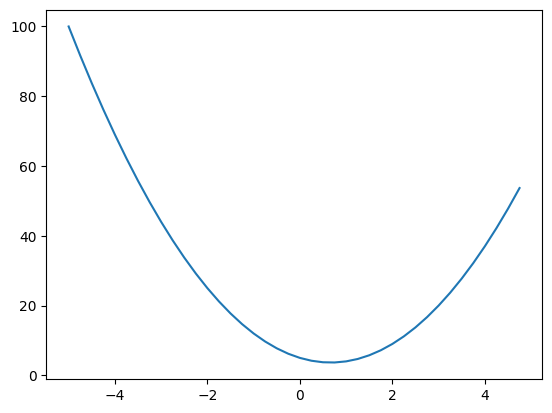

In [7]:
plt.plot(xs, ys)

BackProp mainly calculate the the derivation(means if we slightly change the value of variable, how it effect on the end result) we see this

In [8]:
# The function of the derivation is look like this
h = 0.000001 #if we slightly change the varable by this number or we can say little number then what is the actual difference, is called derivation
x = 2
(f(x+h) - f(x))/h #this is the function how derivation calculate

8.000003001384925

In [9]:
# let get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [10]:
h = 0.001

# inputs
a = 2.0
b = 3.0
c = 10.0

d1 = a*b +c #output->before changing the i/p

a += h #slightly increase the i/p
# you can check for every i/p, and analyse how much the final o/p is different this is called derivation

d2 = a*b +c #output->after changeing i/p

print('d1= ', d1)
print('d2= ', d2)
print('slope= ', (d2 - d1)/h)


d1=  16.0
d2=  16.003
slope=  3.0000000000001137


### Let, do the hole operations using class components

In [11]:
class Value:

  # _children() => it stores the operand
  # example: d = (a + b) --> the add / mul class return the d
  # and the _prev return the value of a & b
  # and "_op" store the operator(+,-,*,/, etc)
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0 #starting the "gradient = 0", means no change, this is the variable where we make change and see the "loss function become decreasing or not"
    self._backward = lambda: None #the "lambda" doesn't do anything

# _______________________________________________________________________________________________

  # this function is also like constructor run at compile time
  # it is used for showing data in beautify manner, otherwise python show in different un-readable manner
  def __repr__(self):
    return f"Value(data={self.data})"

# _______________________________________________________________________________________________

  # (a+b) -> self = a, other = b
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data + other.data, (self, other), '+') #create the Value object and return

    # do the derivativation with help of the graph to understand, it is very easy to understand
    def _backward():
      self.grad += 1.0 * out.grad #when one variable use more than one time then we need += (multivariate chain rule)
      other.grad += 1.0 * out.grad
    out._backward = _backward # it sotres the "receipe" of this __add__ function's backprop

    return out

# _______________________________________________________________________________________________

  def __mul__(self, other):
    # let, a = Value(3.0); a*2 we can't pass this becauses 2 is int not a Value object, so do the below line
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

# _______________________________________________________________________________________________

  # redefine the Power(x^2,...) function
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

# _______________________________________________________________________________________________

  # If we pass a*2 (a.__mul__(2) =>Correct) but if we pass 2*a(2.__mul__(a)=> ERROR)
  # It simply swap the variables and call the above multiplication function
  def __rmul__(self, other):
    return self * other

# _______________________________________________________________________________________________

  def __radd__(self, other): # other + self
    return self + other

# _______________________________________________________________________________________________

  # define our division function
  # (a/b) => [a * (1/b)] => [a * (b**-1)]
  def __truediv__(self, other):
    return self * other**-1

# _______________________________________________________________________________________________

  # to create a negative value
  def __neg__(self):
    return self * -1

# _______________________________________________________________________________________________

  # for subtraction
  def __sub__(self, other):
    return self + (-other)

# _______________________________________________________________________________________________

  # define tanh() activation function
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) -1) / (math.exp(2*x) + 1) #formula for tanh()
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

# _______________________________________________________________________________________________

  # define our own exponential function
  # and we know the formula d/dx (exp(x)) = exp(x)
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
          self.grad += out.data * out.grad
    out._backward = _backward

    return out

# _______________________________________________________________________________________________

  # doing the backward using the concept of "topological sort"
  # because it maintain the order of doing backward cell upon cell
  # it use to avoid doing backward on any cell at any time
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [13]:
# @title
# This below code block is to just visulaze the workflow of the eqation
# just like flowGraph, just copy code no need to focus much
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### Implemneting Back_Propagation Manually

In [15]:
# @title
# Function is use to check the derivation by slightly changing by h
def lol():

  h = 0.001

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

0.0


#### Tanh() activation function

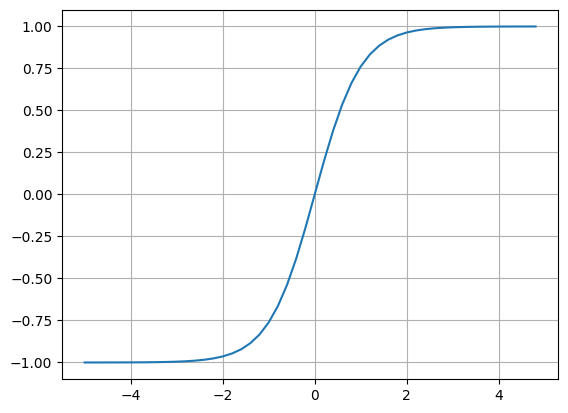

In [16]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [17]:
# In the Logistic Regression the output Z = W1 * X1 + W2*X2 + b (for 2 i/p column/feature)

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# the output let, n = w1*x1 + w2*x2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# call the activation function tanh(), which range the output [-1, 1]
o = n.tanh(); o.label = 'o'


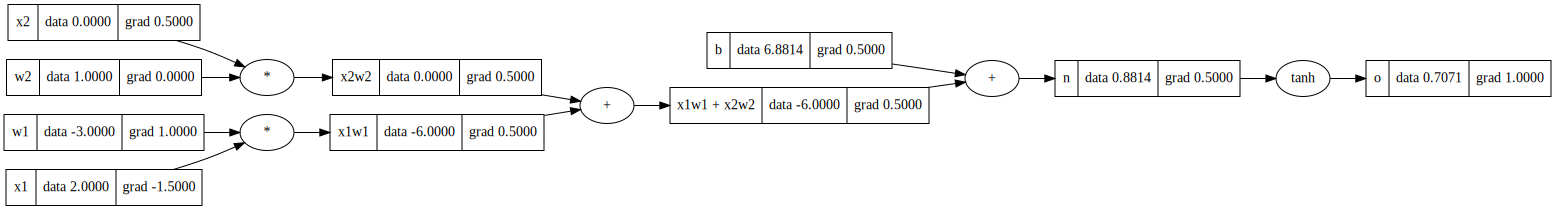

In [18]:
o.backward()
draw_dot(o)

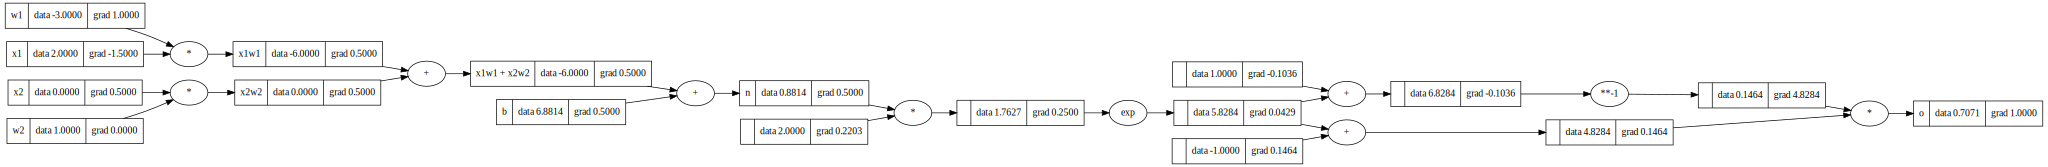

In [20]:
# In the Logistic Regression the output Z = W1 * X1 + W2*X2 + b (for 2 i/p column/feature)

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# the output let, n = w1*x1 + w2*x2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# call the activation function tanh(), which range the output [-1, 1]
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()
draw_dot(o)


### In pyTorch we can do the same thing
- In pyTorch Tensors are used but in our simple class we use scalar(0 tensor) use for demonstrate simply.
- vector is (1 tensor) and matrix is (2 tensor) and so on use for multi-dimensional data.

In [21]:
import torch

In [23]:
# In pyTorch by default x1, x2, w1, w2 and b has no gradient attribute for efficiency purpose
# but in this we require them, so simply write "x1.requires_grad  = True"
x1 = torch.Tensor([2.0]).double(); x1.requires_grad  = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("____________________________________")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
____________________________________
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Now implement more Hidden Layers in Neural Network
- Remember that "Neuron" is nothing but a Mathematical function which do some type of Mathematical operations when we pass some inputs to that function and give a output

In [77]:
import random

class Neuron:

  def __init__(self, nin):

    # Weights and we use random weights between [-1, 1]
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #"nin"=>no. of i/p column
    # Bias
    self.b = Value(random.uniform(-1,1)) # it always only one scalar value or sigle value object

  def __call__(self, x):
    # w * x + b
    # zip(self.w, x) => it mainly zip or store 2 variable as one object
    # like=> (Value(data=-0.4345252167276419), 2.0)
    # value-1: "Value(data=-0.4345252167276419)" & value-2: "2.0"
    # print(list(zip(self.w, x))) # and list show all the combination of 2 pairs which made by zip
    # act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b[0] #we can use the sum function to sum the bias inside
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  # This parameters function will help us, when we need to increase the weight and bias slightly
  # for reduce the loss function
  def parameters(self):
    return self.w + [self.b] # list1 + list2 = [list1, list2] so return a single list

#___________________________________________________________________________________________________

# It is help to make a sigle layer of the neural netowrk
# by taking inputs 1. no. of i/p & 2.no. of node/neuron on this layer
class Layer:

    # "nin"->no. of i/p column | "nout"->no. of neuron/node you want in a layer
    def __init__(self, nin, nout):
      self.neurons = [Neuron(nin) for _ in range(nout)] #it basically call the "Neuron" calss "nout" times and store the neuron o/p values in a list

    def __call__(self, x):
      outs = [n(x) for n in self.neurons]
      return outs[0] if len(outs) == 1 else outs

    def parameters(self):
      # return [p for neuron in self.neurons for p in neuron.parameters()]
      # the above line is doing same as the below code
      params = []
      for neuron in self.neurons:
        ps = neuron.parameters()
        params.extend(ps)
      return params

#___________________________________________________________________________________________________

# It taking inputs 1. no. of i/p & 2. taking a List(which cotains every Layers node/neuron count)
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts # if we do "nin + nouts"-> it gives ERROR, because "nouts"->is list so we make "nin"->list
    # print(sz) # for "nin = 2" & "nouts=[3,4,3]" => sz=[2,3,4,3] simply joint 2 list
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] #

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [82]:
x = [2.0, 3.0, -1.0]
l = [4, 4, 1]
n = MLP(3, l)
n(x)

Value(data=-0.14336410087799867)

In [83]:
n.parameters() #finally it gives the list of all the weights(w) & biases(b) values, which using in the created neural network

[Value(data=0.573165197896139),
 Value(data=0.9465060324719481),
 Value(data=0.03372829578073633),
 Value(data=0.07525246181350442),
 Value(data=0.5481395250055756),
 Value(data=0.09782338018143566),
 Value(data=-0.9088996560259344),
 Value(data=-0.17218955348502907),
 Value(data=0.5840830123279397),
 Value(data=-0.19331340473522385),
 Value(data=0.7606792869575647),
 Value(data=0.8839890006677569),
 Value(data=-0.5935326180751153),
 Value(data=-0.9393064392427695),
 Value(data=-0.24200530247206697),
 Value(data=0.9144635553975504),
 Value(data=-0.3331891224149901),
 Value(data=-0.7809360531916607),
 Value(data=-0.8600817337446731),
 Value(data=0.14604407926008012),
 Value(data=-0.911779709282917),
 Value(data=-0.3182951268812817),
 Value(data=0.7556058841159277),
 Value(data=0.3238496438392189),
 Value(data=0.8311959697013906),
 Value(data=-0.2364261831151342),
 Value(data=0.5289935148040619),
 Value(data=-0.262152516847012),
 Value(data=0.4801681401065043),
 Value(data=0.535822746972

In [84]:
len(n.parameters())

41

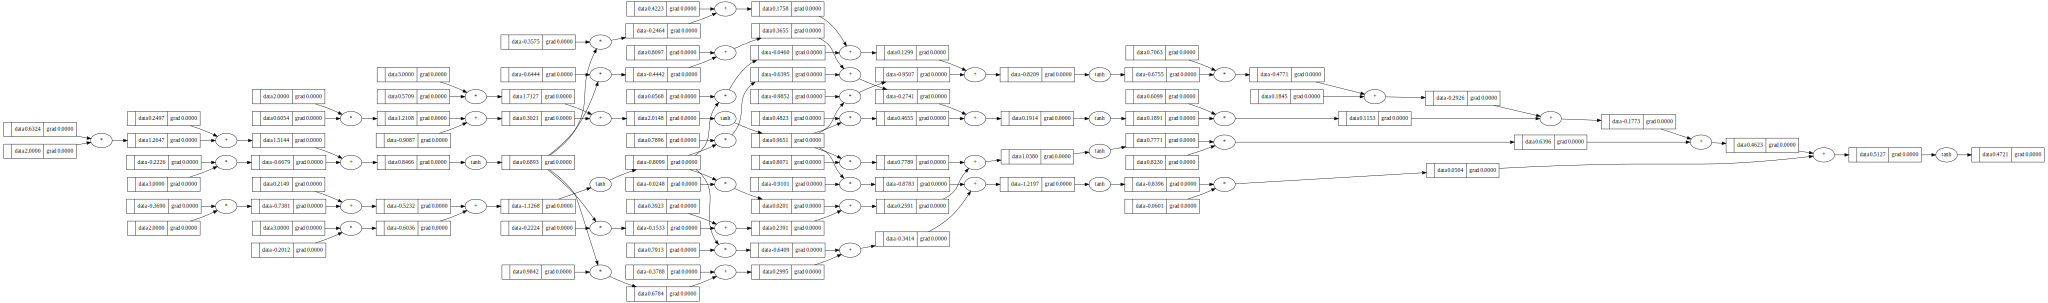

In [68]:
# @title
draw_dot(n(x))

##### Now, creating a small dummy Training data set to check our Neural Network operations how it correct its gradiant
- and Estimate the Loss using "mean squred error"
- and try to minimize the loss

In [114]:
# Dummy Training data set
# here, we have 3 i/p column and toatal m=4 training data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0,5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # target/original output, Binary classification problem

n = MLP(3, [4, 4, 1])
# yPred = [n(x) for x in xs]
# yPred

In [89]:
# Here, we calculate the individual Loss of each training data using "Mean Squrad Error" and store them into a list
# "ygt"=actual or original o/p & "yout"=predicted o/p
[(yout - ygt)**2 for ygt, yout in zip(ys, yPred)]

[Value(data=1.3435306244695064),
 Value(data=1.6358186388878644),
 Value(data=0.8414899673574932),
 Value(data=1.129251423803435)]

In [90]:
# Total loss of our model is
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, yPred)])
loss

Value(data=4.9500906545182985)

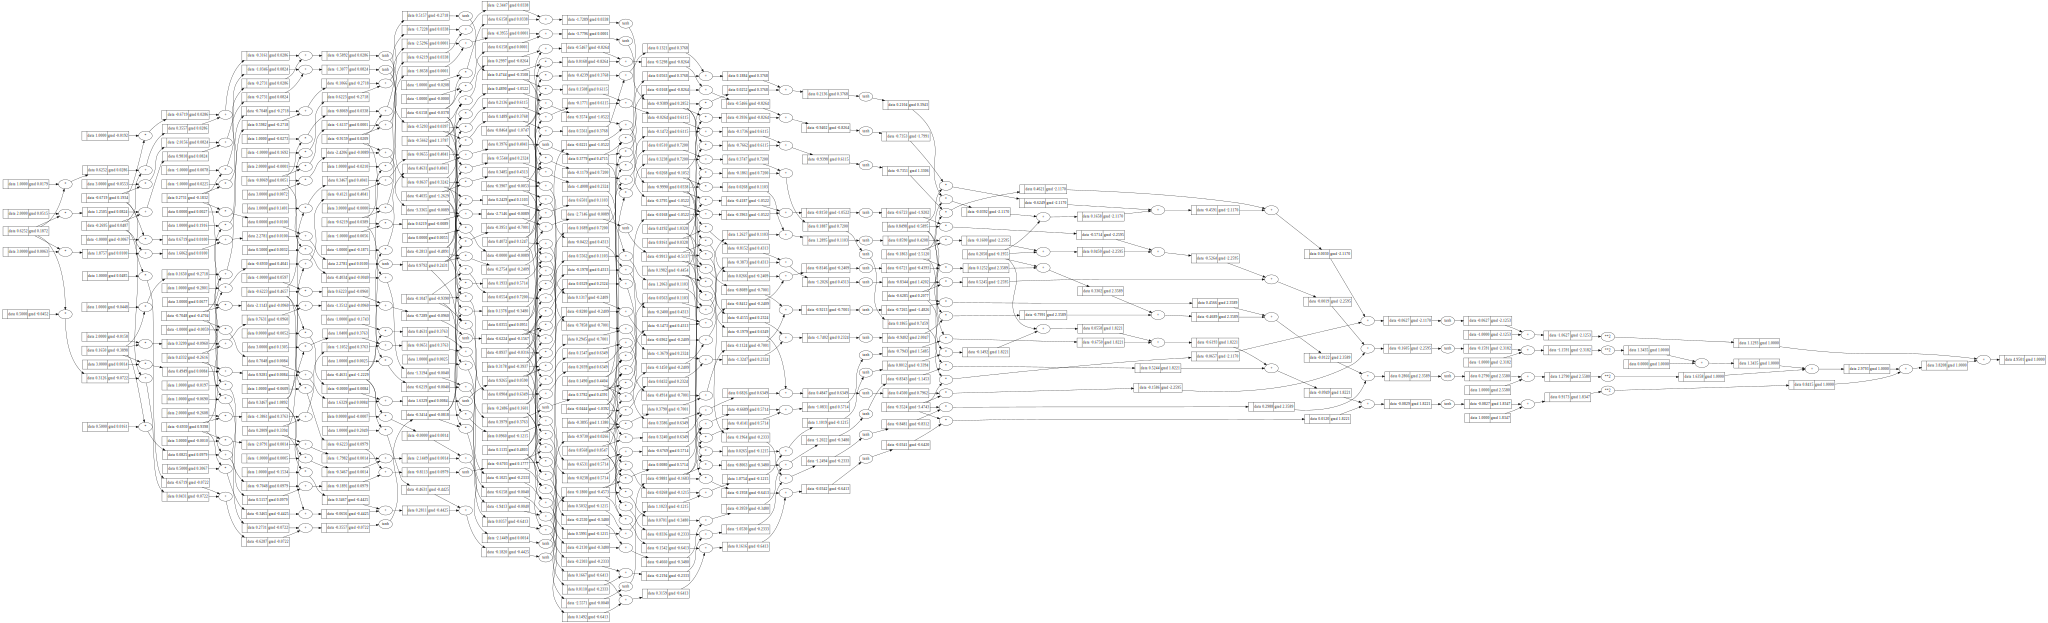

In [91]:
# calculate the gradient of the loss
loss.backward()
draw_dot(loss)

In [95]:
# we can get the specific weights and bias values
# in which we can slightly change and check weather loss is minimize or not
print("Grad: ", n.layers[0].neurons[0].w[0].grad)
print("Data: ", n.layers[0].neurons[0].w[0].data)


Grad:  0.18718365144158675
Data:  0.6252326196984768


In [96]:
# so, to reduces our loss we slightly change on every weights(w) and bias(b)
# this is the main concept of "gradient descent"
# p.data = p.data + 0.01*p.grad => means we take a tiny step in the direction of the vector to go to the bottom most position
# 0.01 => learning rate (also denoted by "alpha")
for p in n.parameters():
  p.data += -0.01 * p.grad

In [99]:
# after taking the above small step in direction to minimize the loss
# we can notice the "data" is slightly decrease, decerease because the "grad" is in (+ve) direction
# but if the "grad" in (-ve) direction, with doing the same operation we can see the data might increase little bit
print("Grad: ", n.layers[0].neurons[0].w[0].grad)
print("Data: ", n.layers[0].neurons[0].w[0].data)

Grad:  0.18718365144158675
Data:  0.6233607831840609


In [101]:
# Check if the loss is changed a little bit or not
yPred = [n(x) for x in xs]
# Total loss of our model is
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, yPred)])
loss
# Success! the loss is dicrease little bit
# *** Now, we need to do the same changing process iteratively, to get the min. loss ***

Value(data=4.622270652186265)

In [134]:
# Let, write the hole thin forwardProp, backProp and Update in one iterative loop
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  # we need to set all grad to 0, before start
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 0.0025456641671376314
1 0.002536384285961851
2 0.0025271696250891685
3 0.0025180195081435544
4 0.0025089332680011305
5 0.0024999102466332214
6 0.002490949794952654
7 0.002482051272663129
8 0.0024732140481116315
9 0.0024644374981437622
10 0.002455721007962064
11 0.0024470639709869195
12 0.0024384657887205046
13 0.002429925870613239
14 0.002421443633932908
15 0.0024130185036363464
16 0.0024046499122437155
17 0.0023963372997150498
18 0.002388080113329422
19 0.002379877807566293


In [136]:
ypred
# it gives the nearly accurate answer for my little data set

[Value(data=0.9759559072584734),
 Value(data=-0.9671265761560891),
 Value(data=-0.9847933922478123),
 Value(data=0.9778672980128306)]